In [26]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, variation
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from sequencing_tools.viz_tools import color_encoder
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

def model_var(phi, mu):
    return mu * (1 + phi * mu)
    
def model_cv(phi, mu):
    var = model_var(phi, mu)
    cv = np.sqrt(var) / mu
    return cv

def fit_dispersion(phi, mu, var):
    pred_var = model_var(phi, mu)
    return mean_squared_error(var, pred_var)

For RNA-seq, [variance](https://academic.oup.com/nar/article/45/11/e104/3091649) can be modeled by:

$$ \sigma^2 = \mu (1+\phi \mu)  $$

In [2]:
df = pd.read_table('../data/NTT_norm.counts') \
    .assign(seq_id = lambda d: np.arange(d.shape[0]))
df.head()

,NTCF1,NTCF2,NTCF3,NTTF1,NTTF2,NTTF3,seq_id
100169835,0.000000,0.000000,0.000000,0.343471,0.000000,0.000000,0
100169836,1.702180,1.137944,0.000000,1.030413,0.417699,0.000000,1
100169837,66.385017,120.242700,48.253331,102.697851,86.254941,37.280053,2
100379658,5.787412,11.758750,3.760000,7.899835,6.056642,2.982404,3
100379663,2.383052,1.517258,0.000000,1.717355,2.088497,1.864003,4


In [3]:
mv_df = pd.melt(df, id_vars = ['seq_id'], var_name = 'samplename', value_name = 'norm_count')\
    .assign(prep = lambda d: d.samplename.str.replace('[0-9]+$',''))\
    .groupby(['seq_id','prep'], as_index=False) \
    .agg({'norm_count':['mean','std','var',variation]}) 
new_col = mv_df.columns.get_level_values(0) + mv_df.columns.get_level_values(1)
mv_df.columns = new_col

mv_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:999: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


,seq_id,prep,norm_countmean,norm_countstd,norm_countvar,norm_countvariation
0,0,NTCF,0.000000,0.000000,0.000000,NaN
1,0,NTTF,0.114490,0.198303,0.039324,1.414214
2,1,NTCF,0.946708,0.867054,0.751782,0.747798
3,1,NTTF,0.482704,0.518273,0.268607,0.876662
4,2,NTCF,78.293683,37.443018,1401.979578,0.390480


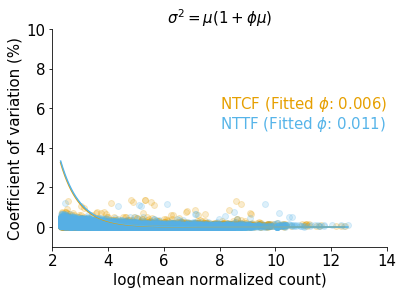

In [31]:
ax = plt.subplot(111)
prep_ce = color_encoder()
prep_ce.fit(mv_df.prep.unique())
for i, (prep, prep_d) in enumerate(mv_df.groupby('prep')):
    
    sub_d = prep_d[prep_d['norm_countmean'] > 10]
    gene_mu = sub_d['norm_countmean']
    gene_cv =  sub_d['norm_countvariation']
    gene_var = sub_d['norm_countvar']
    
    fitted = minimize(fit_dispersion, [2], args = (gene_mu, gene_var))
    phi = fitted.x[0]
    
    modeled_mean = np.arange(gene_mu.min(), 100, 0.1)
    modeled_mean = np.append(modeled_mean, np.arange(100, gene_mu.max()))
    modeled_var = model_var(phi, modeled_mean)
    modeled_std = np.sqrt(modeled_var) / modeled_mean
    modeled_cv = modeled_std/modeled_mean
    
    color = prep_ce.encoder[prep]
    disp = prep + ' (Fitted $\phi$: %.3f)' %phi
    ax.plot(np.log(modeled_mean), modeled_cv*100, color = color)
    ax.scatter(np.log(gene_mu), gene_cv, alpha=0.2, color = color)
    ax.text(8,6 - i, disp, fontsize=15, color = color)
ax.set_xlim(2, 14)
ax.set_ylim(-1,10)  
ax.set_xlabel('log(mean normalized count)')
ax.set_ylabel('Coefficient of variation (%)')
ax.set_title(r'$\sigma^2 = \mu (1+\phi \mu)$', size=15)
sns.despine()

In [99]:
def plot_mean_var(mv_df, ax, log_scale=False):
    prep_ce = color_encoder()
    prep_ce.fit(mv_df.prep.unique())
    
    for i, (prep, prep_d) in enumerate(mv_df.groupby('prep')):
    
        gene_mu = prep_d['norm_countmean']
        gene_cv =  prep_d['norm_countvariation']
        gene_var = prep_d['norm_countvar']
    
        fitted = minimize(fit_dispersion, [2], args = (gene_mu, gene_var))
        phi = fitted.x[0]
    
        modeled_mean = np.arange(gene_mu.min(), 100, 0.1)
        modeled_mean = np.append(modeled_mean, np.arange(100, gene_mu.max()))
        modeled_var = model_var(phi, modeled_mean)
        modeled_std = np.sqrt(modeled_var) / modeled_mean
        modeled_cv = modeled_std/modeled_mean
    
    
        color = prep_ce.encoder[prep]
        disp = prep + ' ($\phi$: %.3f)' %phi
    
        if log_scale:
            ax.plot(np.log(modeled_mean), np.log(modeled_var), color = color)
            ax.scatter(np.log(gene_mu), np.log(gene_var), alpha=0.1, color = color)
            ax.text(1, 18 - i*2, disp, fontsize=15, color = color)
    
        else:
            ax.plot(modeled_mean, modeled_var, color = color)
            ax.scatter(gene_mu, gene_var, color = color, alpha=0.8)
            ax.text(1e5, 1e9 - i*1e8, disp, fontsize=15, color = color)

    if log_scale:
        ax.set_xlim(0,12)
        ax.set_ylim(0,20)
        ax.set_xlabel('log($\mu$)')
        ax.set_ylabel('log($\sigma^2$)')
        
    else:
        xt = np.arange(0,mv_df.norm_countmean.max(), 5e4)
        ax.set_xlim(0, mv_df.norm_countmean.max())
        ax.set_xticks(xt)
        ax.set_xticklabels(xt, rotation = 70,
                          rotation_mode = 'anchor', ha = 'right')
        ax.set_xlabel('$\mu$')
        ax.set_ylabel('$\sigma^2$')

    ax.plot([0,1e9], [0,1e9], color='red')
    sns.despine()

    ax.set_title(r'$\sigma^2 = \mu (1+\phi \mu)$', size=15)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


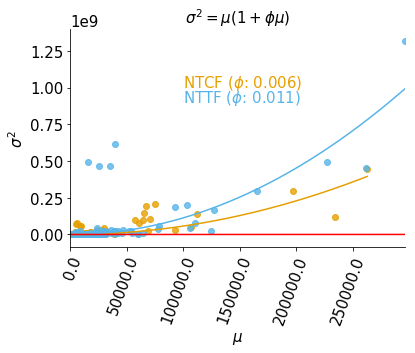

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_mean_var(mv_df, ax, log_scale = False)
fig.savefig('../figures/mean_var_plot.eps')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel

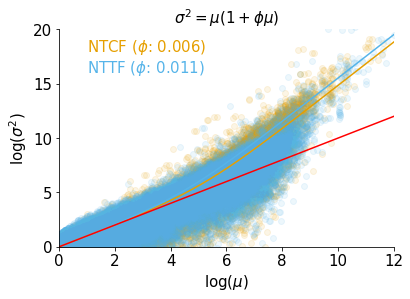

In [101]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_mean_var(mv_df, ax, log_scale = True)
fig.savefig('../figures/mean_var_plot_log.eps')